# Location Entropy

### Load Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load EPFL Dataset

In [ ]:
# Function to load EPFL dataset
def load_epfl_dataset(folder_path):
    all_records = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt") and filename != "_cabs.txt":
            user_id = filename.replace(".txt", "")
            file_path = os.path.join(folder_path, filename)

            df = pd.read_csv(
                file_path,
                sep=" ",
                header=None,
                names=["latitude", "longitude", "occupancy", "timestamp"]
            )

            df["user_id"] = user_id
            all_records.append(df)

    if len(all_records) == 0:
        raise ValueError("No .txt files found. Check folder path.")

    return pd.concat(all_records, ignore_index=True)


### Convert GPS Coordinates to Discrete Locations

In [ ]:
# Function to convert GPS coordinates to grid-based location IDs
def gps_to_grid(df, lat_col="latitude", lon_col="longitude", precision=3):
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

    df = df.dropna(subset=[lat_col, lon_col])

    df["location_id"] = (
        df[lat_col].round(precision).astype(str) + "_" +
        df[lon_col].round(precision).astype(str)
    )

    return df


### Compute Location Entropy

In [ ]:
# Function to compute location entropy for each user
def compute_location_entropy(df):

    location_counts = (
        df.groupby(["user_id", "location_id"])
          .size()
          .reset_index(name="visits")
    )

    total_visits = (
        location_counts.groupby("user_id")["visits"]
        .sum()
        .reset_index(name="total_visits")
    )

    merged = location_counts.merge(total_visits, on="user_id")
    merged["p"] = merged["visits"] / merged["total_visits"]

    entropy = (
        merged.groupby("user_id")["p"]
        .apply(lambda x: -np.sum(x * np.log2(x)))
        .reset_index(name="location_entropy")
    )

    return entropy


### Execute the Full Pipeline

In [5]:
folder_path = r"cabspottingdata"

# os.listdir(folder_path)

In [6]:
folder_path = r"cabspottingdata"

df = load_epfl_dataset(folder_path)
df.shape

(11219955, 5)

In [7]:
df.head()

,latitude,longitude,occupancy,timestamp,user_id
0,37.75134,-122.39488,0,1213084687,new_abboip
1,37.75136,-122.39527,0,1213084659,new_abboip
2,37.75199,-122.39460,0,1213084540,new_abboip
3,37.75080,-122.39346,0,1213084489,new_abboip
4,37.75015,-122.39256,0,1213084237,new_abboip


In [8]:
df = gps_to_grid(df, precision=3)
df.head()

,latitude,longitude,occupancy,timestamp,user_id,location_id
0,37.75134,-122.39488,0,1213084687,new_abboip,37.751_-122.395
1,37.75136,-122.39527,0,1213084659,new_abboip,37.751_-122.395
2,37.75199,-122.39460,0,1213084540,new_abboip,37.752_-122.395
3,37.75080,-122.39346,0,1213084489,new_abboip,37.751_-122.393
4,37.75015,-122.39256,0,1213084237,new_abboip,37.75_-122.393


In [9]:
entropy_df = compute_location_entropy(df)
entropy_df.head()

,user_id,location_entropy
0,new_abboip,10.253027
1,new_abcoij,2.885279
2,new_abdremlu,11.128554
3,new_abgibo,10.851199
4,new_abjoolaw,10.603504


In [10]:
# Explore location entropy values
entropy_df["location_entropy"].describe()

count    536.000000
mean      10.490862
std        0.929450
min        0.782228
25%       10.439106
50%       10.698570
75%       10.859281
max       11.397668
Name: location_entropy, dtype: float64

This shows diverse mobility patterns: most users moderately exploratory, few very routine, few highly roaming.

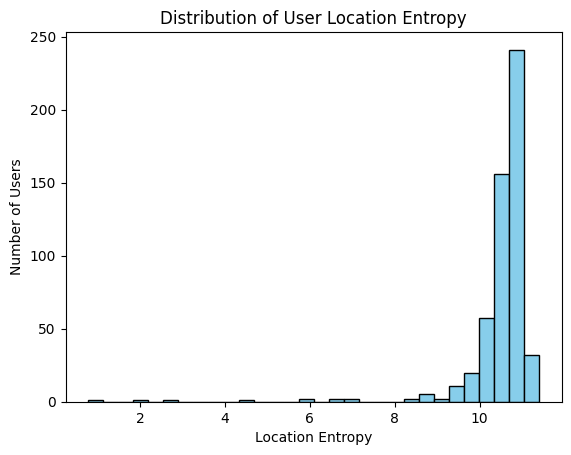

In [ ]:
# Histogram
plt.hist(entropy_df["location_entropy"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Location Entropy")
plt.ylabel("Number of Users")
plt.title("Distribution of User Location Entropy")
plt.show()

- The distribution is left-skewed. Most users have location entropy around 10–11, meaning most users have fairly high location diversity.
- Very few users have very low entropy (below 5), indicating that only a handful are highly predictable in their location patterns.

In [ ]:
# Top 5 users with lowest and highest location entropy
low_entropy = entropy_df.nsmallest(5, "location_entropy")
high_entropy = entropy_df.nlargest(5, "location_entropy")

print("Low Entropy Users:\n", low_entropy)
print("\nHigh Entropy Users:\n", high_entropy)

Low Entropy Users:
           user_id  location_entropy
160  new_egoiwroi          0.782228
285   new_ifeshce          1.868349
1      new_abcoij          2.885279
201    new_eotcue          4.453517
186    new_elvgid          5.766361

High Entropy Users:
           user_id  location_entropy
276   new_idlorra         11.397668
327  new_iorjtwav         11.293149
114   new_eapceou         11.289095
126    new_ecforj         11.280184
19    new_adnerst         11.271270


- Low entropy 
    - easier to predict movements
    - good for route optimization, local services.
- High entropy
    - harder to predict movements
    - good for discovery-based services, city-wide analytics, anomaly detection.

In [ ]:
# Daily Location Entropy Analysis (Temporal Entropy Variation)
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['timestamp'].dt.date

# Compute daily entropy per user
daily_counts = df.groupby(['user_id', 'date', 'location_id']).size().reset_index(name='visits')
daily_totals = daily_counts.groupby(['user_id', 'date'])['visits'].sum().reset_index(name='total_visits')
daily_merged = daily_counts.merge(daily_totals, on=['user_id','date'])
daily_merged['p'] = daily_merged['visits'] / daily_merged['total_visits']

daily_entropy = (
    daily_merged.groupby(['user_id','date'])['p']
    .apply(lambda x: -np.sum(x*np.log2(x)))
    .reset_index(name='daily_entropy')
)

daily_entropy.head()

,user_id,date,daily_entropy
0,new_abboip,2008-05-17,8.318408
1,new_abboip,2008-05-18,6.633795
2,new_abboip,2008-05-19,8.027331
3,new_abboip,2008-05-20,8.467782
4,new_abboip,2008-05-21,4.983987


In [ ]:
# Weekday vs Weekend Location Entropy Analysis
df['weekday'] = df['timestamp'].dt.weekday
df['day_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

day_counts = df.groupby(['user_id','day_type','location_id']).size().reset_index(name='visits')
day_totals = day_counts.groupby(['user_id','day_type'])['visits'].sum().reset_index(name='total_visits')
day_merged = day_counts.merge(day_totals, on=['user_id','day_type'])
day_merged['p'] = day_merged['visits'] / day_merged['total_visits']

day_entropy = (
    day_merged.groupby(['user_id','day_type'])['p']
    .apply(lambda x: -np.sum(x*np.log2(x)))
    .reset_index(name='day_entropy')
)

day_entropy.head()

,user_id,day_type,day_entropy
0,new_abboip,Weekday,10.152862
1,new_abboip,Weekend,9.631031
2,new_abcoij,Weekday,3.340496
3,new_abcoij,Weekend,1.641878
4,new_abdremlu,Weekday,10.969545


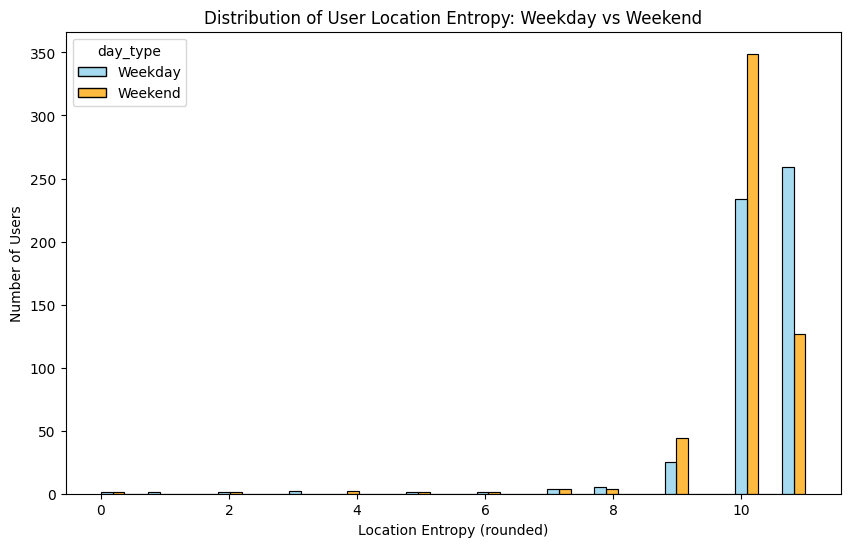

In [ ]:
# Visualization: Weekday vs Weekend Location Entropy
plt.figure(figsize=(10,6))

# Create a temporary column for plotting, rounded to nearest integer
day_entropy['day_entropy_rounded'] = day_entropy['day_entropy'].round(0)

# Map exact hue values to colors
palette = {'Weekday': 'skyblue', 'Weekend': 'orange'}

sns.histplot(
    data=day_entropy,
    x='day_entropy_rounded',
    hue='day_type',
    bins=30,
    palette=palette,
    multiple='dodge'  # prevents stacking bars
)

plt.xlabel("Location Entropy (rounded)")
plt.ylabel("Number of Users")
plt.title("Distribution of User Location Entropy: Weekday vs Weekend")
plt.show()


### Insights and Discussion
<b>Behavioral Segmentation</b>

Location entropy allows classification of users into:
- Routine-based movers
- Exploratory or high-coverage movers

This segmentation is valuable for both operational optimization and strategic decision-making.

<br>

<b>Urban Mobility Insights</b>

High-entropy areas often correspond to:
- Commercial districts
- Tourist zones
- Transport hubs

Low-entropy areas may indicate residential or specialized zones.

<hr>

### Product Ideas
<b>Product Idea 1: Mobility-Based User Segmentation</b>
- Segment users by entropy: routine vs exploratory
- Applications:
    - Targeted services
    - Urban planning
    - Transportation optimization

<b>Product Idea 2: Anomaly Detection</b>
- Monitor sudden changes in user entropy
- Use cases:
    - Fraud detection
    - Vehicle misuse
    - Emergency detection

<b>Product Idea 3: Personalized Recommendations</b>
- Low entropy - recommend nearby services
- High entropy - recommend discovery-based offers
- This directly addresses their “creative application” feedback.